202020986 이승진

필요한 라이브러리 설치

In [76]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install tensorflow
%pip install keras
%pip install --upgrade scikit-learn
%pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 와인 리뷰 데이터 전처리 및 분석

## 라이브러리 임포트
필요한 라이브러리를 임포트합니다. 이 라이브러리들은 데이터 처리, 모델 학습, 성능 평가 등을 위해 사용됩니다.

In [77]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
df = pd.read_csv('wine_review.csv')

# 필요한 컬럼만 선택하기
df = df[['reviews.text', 'reviews.rating', 'reviews.title', 'reviews.doRecommend', 'name']]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviews.text         2889 non-null   object 
 1   reviews.rating       2445 non-null   float64
 2   reviews.title        2846 non-null   object 
 3   reviews.doRecommend  1911 non-null   object 
 4   name                 2890 non-null   object 
dtypes: float64(1), object(4)
memory usage: 113.0+ KB


# 데이터 전처리 및 텍스트 전처리

## 결측치 처리
먼저, 데이터프레임 `df`에서 특정 컬럼들에 결측치가 있는 행을 제거합니다. 사용된 컬럼은 다음과 같습니다:
- `reviews.text`
- `reviews.rating`
- `reviews.title`
- `reviews.doRecommend`

In [78]:

# 결측치 처리 (간단한 방법으로 결측치가 있는 행 제거)
df.dropna(subset=['reviews.text', 'reviews.rating', 'reviews.title', 'reviews.doRecommend'], inplace=True)

# 텍스트 데이터 전처리 함수 정의
def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'\s+', ' ', text)  # 공백 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    return text

# 텍스트 컬럼 전처리
df['reviews.text'] = df['reviews.text'].apply(preprocess_text)
df['reviews.title'] = df['reviews.title'].apply(preprocess_text)


# VADER 감정 분석을 통한 리뷰 감정 분석

## VADER 감정 분석기 초기화
VADER (Valence Aware Dictionary for Sentiment Reasoning) 감정 분석기를 초기화합니다. VADER는 텍스트의 감정 점수를 계산하는 데 사용됩니다.

In [79]:

# VADER 감정 분석기 초기화
analyzer = SentimentIntensityAnalyzer()

# VADER를 사용하여 감정 점수 계산
def vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

df['sentiment_score'] = df['reviews.text'].apply(vader_sentiment)

# 감정 레이블 생성 (VADER 점수가 0.05 이상이면 긍정, -0.05 이하이면 부정)
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 1 if x >= 0.05 else (0 if x <= -0.05 else 2))

# 중립 감정을 제거 (VADER 점수가 -0.05 ~ 0.05 사이인 경우)
df = df[df['sentiment_label'] != 2]

# 텍스트 데이터의 감정 분석을 위한 모델 학습

## 학습 및 테스트 데이터 분리
리뷰 텍스트(`reviews.text`)와 감정 레이블(`sentiment_label`)을 학습 및 테스트 데이터로 분리합니다. 데이터의 20%를 테스트 데이터로 사용합니다.

In [80]:
# 학습 및 테스트 데이터 분리
X = df['reviews.text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 파이프라인 구성
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

# 하이퍼파라미터 그리드 설정
param_grid = {
    'tfidf__max_features': [5000, 7000, 10000],  # TfidfVectorizer의 max_features
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # TfidfVectorizer의 ngram_range
    'classifier__C': [0.1, 1, 10, 100]  # LogisticRegression의 C (정규화 강도)
}

# 그리드 서치 실행
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 모델의 견고성 평가 및 최종 테스트

## 교차 검증을 사용하여 모델의 견고성 평가
최적 모델을 사용하여 교차 검증을 통해 모델의 견고성을 평가합니다.
- `cv=5`: 5-폴드 교차 검증을 사용하여 모델을 평가합니다.
- `scoring='accuracy'`: 정확도를 평가 메트릭으로 사용합니다.

In [81]:
# 교차 검증을 사용하여 모델의 견고성 평가
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print("교차 검증 점수: ", cv_scores)
print("평균 교차 검증 점수: ", np.mean(cv_scores))

# 테스트 세트에서 최종 평가
y_pred = best_model.predict(X_test)


교차 검증 점수:  [0.92369478 0.92741935 0.92741935 0.92741935 0.93548387]
평균 교차 검증 점수:  0.9282873429200673


# 모델 평가 지표 계산 및 출력

최종 테스트 세트에서 모델의 성능을 평가하기 위해 다양한 평가 지표를 계산합니다.

## 모델 평가 지표 계산
테스트 세트에 대한 예측 결과(`y_pred`)와 실제 레이블(`y_test`)을 사용하여 다양한 평가 지표를 계산합니다.

In [82]:
# 모델 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("정확도: ", accuracy)
print("정밀도: ", precision)
print("재현율: ", recall)
print("F1 점수: ", f1)
print("ROC-AUC: ", roc_auc)


정확도:  0.9067524115755627
정밀도:  0.9061488673139159
재현율:  1.0
F1 점수:  0.9507640067911715
ROC-AUC:  0.532258064516129


# 혼동 행렬 생성 및 시각화

모델의 성능을 평가하기 위해 혼동 행렬을 생성하고 시각화합니다.

## 혼동 행렬 생성
테스트 세트에 대한 예측 결과(`y_pred`)와 실제 레이블(`y_test`)을 사용하여 혼동 행렬을 생성합니다.

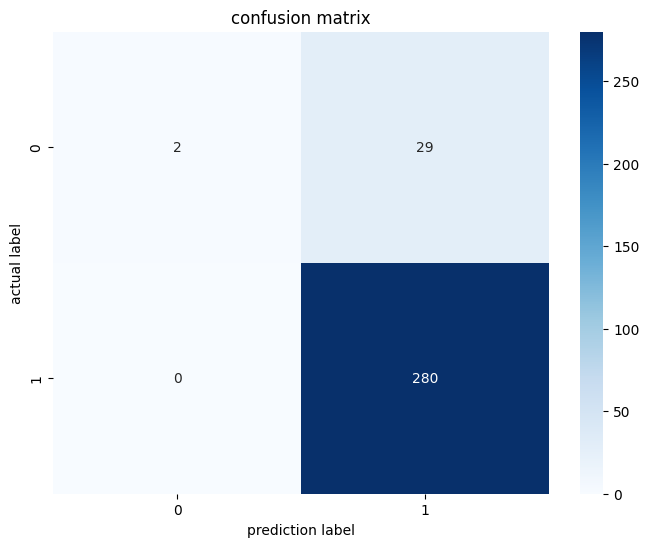

In [83]:
# 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('prediction label')
plt.ylabel('actual label')
plt.show()

# ROC 곡선 생성 및 시각화

모델의 성능을 평가하기 위해 ROC 곡선을 생성하고 시각화합니다.

## ROC 곡선 데이터 생성
테스트 세트에 대한 예측 결과(확률값)를 사용하여 ROC 곡선을 그리기 위한 데이터를 생성합니다.

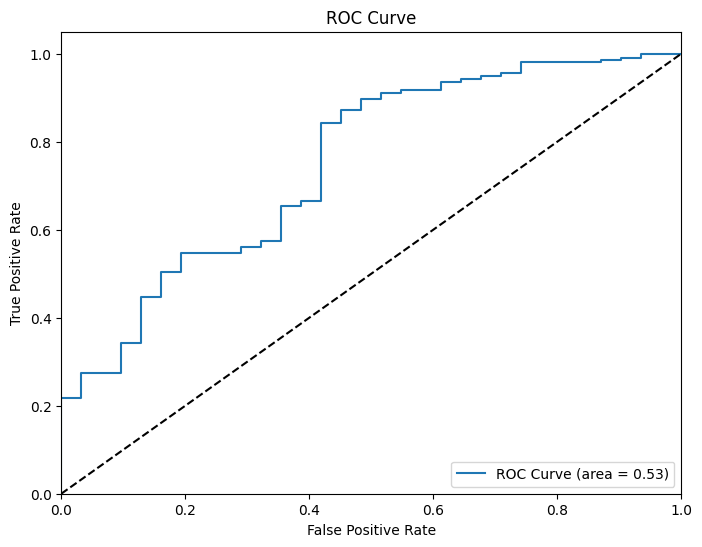

In [84]:
# ROC 곡선 생성 및 시각화
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 오버피팅 및 언더피팅 논의

모델의 훈련 세트와 테스트 세트에 대한 정확도를 계산하고, 이를 바탕으로 오버피팅과 언더피팅 여부를 논의합니다.

## 정확도 계산
훈련 세트와 테스트 세트에 대한 정확도를 계산합니다.

In [85]:
# 오버피팅 및 언더피팅 논의
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print("훈련 세트 정확도: ", train_accuracy)
print("테스트 세트 정확도: ", test_accuracy)

if train_accuracy > test_accuracy:
    print("오버피팅이 의심됩니다. 모델이 훈련 데이터에 과적합되어 테스트 세트에서 성능이 떨어집니다.")
elif train_accuracy < test_accuracy:
    print("언더피팅이 의심됩니다. 모델이 훈련 데이터에 충분히 적합하지 않습니다.")
else:
    print("모델이 적절하게 적합되었습니다.")

# 오버피팅 해결 방법:
# 1. 더 많은 데이터를 수집하여 모델을 학습시킵니다.
# 2. 모델의 복잡도를 줄입니다. (예: 하이퍼파라미터 조정)
# 3. 규제를 추가하거나 규제를 강화합니다.

# 언더피팅 해결 방법:
# 1. 더 복잡한 모델을 사용합니다.
# 2. 하이퍼파라미터를 조정하여 모델의 복잡도를 높입니다.
# 3. 더 많은 특성을 추가합니다.


훈련 세트 정확도:  1.0
테스트 세트 정확도:  0.9067524115755627
오버피팅이 의심됩니다. 모델이 훈련 데이터에 과적합되어 테스트 세트에서 성능이 떨어집니다.
